## K-means++

In this notebook, we are going to implement [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm with multiple initial sets. The original k-means++ algorithm will just sample one set of initial centroid points and iterate until the result converges. The only difference in this implementation is that we will sample `RUNS` sets of initial centroid points and update them in parallel. The procedure will finish when all centroid sets are converged.

In [3]:
# Name: Danyang Zhang
# Email: daz040@eng.ucsd.edu
# PID: A53104006
PYBOLT = False
if PYBOLT:
    from pyspark import SparkContext
    sc = SparkContext()

### Definition of some global parameters.
K = 5  # Number of centroids
RUNS = 25  # Number of K-means runs that are executed in parallel. Equivalently, number of sets of initial points
RANDOM_SEED = 60295531
converge_dist = 0.1 # The K-means algorithm is terminated when the change in the location 
                    # of the centroids is smaller than 0.1

In [4]:
import numpy as np
import pickle
import sys
from numpy.linalg import norm
from matplotlib import pyplot as plt


def print_log(s):
    sys.stdout.write(s + "\n")
    sys.stdout.flush()


def parse_data(row):
    '''
    Parse each pandas row into a tuple of (station_name, feature_vec),
    where feature_vec is the concatenation of the projection vectors
    of TAVG, TRANGE, and SNWD.
    '''
    return (row[0],  # station name 
            np.concatenate([row[1], row[2], row[3]])  # TAVG, TRANGE, and SNWD
           ) 


def compute_entropy(d):
    '''
    Compute the entropy given the frequency vector `d`
    Vectorized 
    '''
    d = np.array(d)
    d = 1.0 * d / d.sum()
    return -np.sum(d * np.log2(d))


def choice(p):
    '''
    Generates a random sample from [0, len(p)),
    where p[i] is the probability associated with i. 
    '''
    random = np.random.random()
    r = 0.0
    for idx in range(len(p)):
        r = r + p[idx]
        if r > random:
            return idx
    assert(False)


def kmeans_init(rdd, K, RUNS, seed):
    '''
    Select `RUNS` sets of initial points for `K`-means++
    '''
    # the `centers` variable is what we want to return
    n_data = rdd.count()  # T
    shape = rdd.take(1)[0][1].shape[0]  # from parse_data, shape=dim=9
    centers = np.zeros((RUNS, K, shape))

    def update_dist(vec, dist, k):
        new_dist = norm(vec - centers[:, k], axis=1)**2  # col vector 
        return np.min([dist, new_dist], axis=0)


    # The second element `dist` in the tuple below is the closest distance from
    # each data point to the selected points in the initial set, where `dist[i]`
    # is the closest distance to the points in the i-th initial set (RUNS).

    # data point -> dist
    data = rdd.map(lambda p: (p, [np.inf]*RUNS)).cache()  
    
    # Collect the feature vectors of all data points beforehand, might be
    # useful in the following for-loop
    local_data = rdd.map(lambda (name, vec): vec).collect()
    local_data = np.array(local_data)
    # Randomly select the FIRST center point for every run of k-means++,
    # i.e. randomly select `RUNS` points and add it to the `centers` variable
    sample = [local_data[run] for run in np.random.randint(0, len(local_data), RUNS)]
    centers[:, 0] = sample  # shape: (RUNS, K, shape), the first 
    
    
    # after selecting the first centroid, select the remaining 
    for idx in range(K - 1):
        ##############################################################################
        # Insert your code here:
        ##############################################################################
        # In each iteration, you need to select one point for each set
        # of initial points (so select `RUNS` points in total).
        # For each data point x, let D_i(x) be the distance between x and
        # the nearest center that has already been added to the i-th set.
        # Choose a new data point for i-th set using a weighted probability
        # where point x is chosen with probability proportional to D_i(x)^2
        ##############################################################################      
        c = idx
        c_new = idx + 1  # choosing the (i+1)-th centroid 
        
        ## Numpy Vectorization
        dp = np.repeat(local_data[np.newaxis, :], RUNS, axis=0)
        dist = np.zeros((RUNS, n_data), dtype=np.float64) + np.inf
        for c in xrange(c_new):  # No Need, consider loop invariant of min_dist
            new_dist = norm(dp - np.repeat(centers[:, c][:, np.newaxis], n_data, axis=1), axis=2)**2  # col vector 
            dist = np.minimum(dist, new_dist)

        ## Naive 
        #for t in xrange(n_data):
        #    dist[:, t] = update_dist(dp[:, t], dist[:, t], c)

        ## Spark
        #data = data.map(lambda (p, dist): (p, update_dist(p[1], dist, c)))  # p[1] is the vec
        #dist = np.array(data.values().collect()).T
        
        assert dist.shape == (RUNS, n_data)
        
        # normalized to calculate probability, with another dimension RUNS
        dist_sum = np.sum(dist, axis=1)
        prob = np.divide(dist, np.repeat(dist_sum[:, np.newaxis], n_data, axis=1))
        
        ## Naive
        #for r in xrange(RUNS):
        #    i = choice(P[r])            
        #    centers[r, c_new] = local_data[i]
        
        ## Vectorize for axis of RUNS
        i = np.apply_along_axis(choice, 1, prob)            
        centers[:, c_new] = local_data[i]  # dp: (RUNS, T, dim)

    return centers


# why not vectorize - using spark MapReduce
def get_closest(p, centers):
    '''
    Get closes for each run 
    Return the indices the nearest centroids of `p`.
    `centers` contains sets of centroids, where `centers[r]` is
    the r-th set of centroids. (RUNS)
    '''
    best = [0] * len(centers)
    closest = [np.inf] * len(centers)
    for r in range(len(centers)):
        for k in range(len(centers[0])):
            temp_dist = norm(p - centers[r][k])
            if temp_dist < closest[r]:
                closest[r] = temp_dist
                best[r] = k
    return best


def kmeans(rdd, K, RUNS, converge_dist, seed):
    '''
    Run K-means++ algorithm on `rdd`, where `RUNS` is the number of
    initial sets to use.
    '''
    k_points = kmeans_init(rdd, K, RUNS, seed)
    print_log("Initialized.")
    temp_dist = 1.0

    iters = 0
    st = time.time()
    
    n_data = rdd.count()  # T
    shape = rdd.take(1)[0][1].shape[0]  # from parse_data, shape=dim=3
    local_data_rdd = rdd.map(lambda (name, vec): vec).cache()
    local_data = np.array(local_data_rdd.collect())
    
    while temp_dist > converge_dist:
        ##############################################################################
        # INSERT YOUR CODE HERE
        ##############################################################################
        
        # Update all `RUNS` sets of centroids using standard k-means algorithm
        # Outline:
        #   - For each point x, select its nearest centroid in i-th centroids set
        #   - Average all points that are assigned to the same centroid
        #   - Update the centroid with the average of all points that are assigned to it
        
        # Insert your code here
        new_points = {}
        
        ## Numpy vectorization
        # C = np.apply_along_axis(lambda x: get_closest(x, k_points), 1, local_data)        
        
        ## Naive
        #for t in xrange(n_data):
        #    c = get_closest(local_data[t], k_points)
        #    for r, k in enumerate(c):
        #        cluster[(r, k)].append(local_data[t])
        
        ## Spark 
        C = local_data_rdd.map(lambda x: get_closest(x, k_points))
        C = np.array(C.collect())
        assert C.shape == (n_data, RUNS)  # (t, r) -> cluster label
        for r in xrange(RUNS):
            for k in xrange(K):
                cluster_dp = local_data[C[:, r]==k]  # cluster data point
                new_points[(r, k)] = cluster_dp.mean(axis=0)
                ## otherwise, spark reduce is slower than collect for numpy due to overhead of reduce
    
        # You can modify this statement as long as `temp_dist` equals to
        # max( sum( l2_norm of the movement of j-th centroid in each centroids set ))
        ##############################################################################
        temp_dist = np.max([
                np.sum([norm(k_points[r, k] - new_points[(r, k)]) for k in range(K)])
                for r in range(RUNS)
        ])   # move distance, max over all runs & all points 

        iters = iters + 1
        if iters % 5 == 0:
            print_log("Iteration %d max shift: %.2f (time: %.2f)" %
                      (iters, temp_dist, time.time() - st))
            st = time.time()

        # update old centroids
        # You modify this for-loop to meet your need
        for ((r, k), p) in new_points.items():  ## pattern matching in python dict
            k_points[r, k] = p

    return k_points

In [5]:
## Read data
if PYBOLT:
    path = "../Data/Weather/stations_projections.pickle"
else:
    path = "../../Data/Weather/stations_projections.pickle"
    
data = pickle.load(open(path, "rb"))
rdd = sc.parallelize([parse_data(row[1]) for row in data.iterrows()])
rdd.take(1)

[(u'USC00044534', array([  3.04796236e+03,   1.97434852e+03,   1.50560792e+02,
          -2.90363288e+03,  -2.36907268e+02,   1.47021791e+02,
           1.91503001e-01,   1.87262808e-01,  -4.01379553e-02]))]

In [6]:
# main code

import time

st = time.time()

np.random.seed(RANDOM_SEED)
centroids = kmeans(rdd, K, RUNS, converge_dist, np.random.randint(1000))
group = rdd.mapValues(lambda p: get_closest(p, centroids)).collect()

print "Time takes to converge:", time.time() - st

Initialized.
Iteration 5 max shift: 3211.03 (time: 24.43)
Iteration 10 max shift: 1928.05 (time: 20.41)
Iteration 15 max shift: 693.41 (time: 18.94)
Iteration 20 max shift: 348.29 (time: 17.63)
Iteration 25 max shift: 235.29 (time: 20.81)
Iteration 30 max shift: 185.35 (time: 21.44)
Iteration 35 max shift: 51.71 (time: 23.75)
Iteration 40 max shift: 45.07 (time: 23.32)
Iteration 45 max shift: 26.03 (time: 19.06)
Iteration 50 max shift: 15.59 (time: 18.09)
Iteration 55 max shift: 0.85 (time: 18.69)
Time takes to converge: 235.439112902


## Verify your results
Verify your results by computing the objective function of the k-means clustering problem.

In [7]:
def get_cost(rdd, centers):
    '''
    Compute the square of l2 norm from each data point in `rdd`
    to the centroids in `centers`
    '''
    def _get_cost(p, centers):
        best = [0] * len(centers)
        closest = [np.inf] * len(centers)
        for idx in range(len(centers)):
            for j in range(len(centers[0])):
                temp_dist = norm(p - centers[idx][j])
                if temp_dist < closest[idx]:
                    closest[idx] = temp_dist
                    best[idx] = j
        return np.array(closest)**2
    
    cost = rdd.map(lambda (name, v): _get_cost(v, centroids)).collect()
    return np.array(cost).sum(axis=0)

cost = get_cost(rdd, centroids)

In [8]:
log2 = np.log2

print log2(np.max(cost)), log2(np.min(cost)), log2(np.mean(cost))

33.8254902123 33.7575332525 33.7790236109


## Plot the increase of entropy after multiple runs of k-means++

$$
H(G^{(1)}, G^{(2)}) = H(D) 
$$

For $i$-th element in $D$, $D_i$ is for $i$-th data point $X^{(i)}$, with the probability/frequency of tuple $(r^{(1)}_i, r^{(2)}_i)$, where $r^{(t)}_i$ is the centroid of the cluster containing $X^{(i)}$ in clustering run $G^{(t)}$.

Test the consistency of different clustering runs. 

In [11]:
from collections import defaultdict
entropy = []

print group[0]

for r in range(RUNS):
    count = defaultdict(int)
    for dp, cluster in group:  # cluster hereby represented by its center point 
        cluster_vec = ','.join(map(str, cluster[:r+1]))
        count[cluster_vec] += 1
        
    entropy.append(compute_entropy(count.values()))  # frequency vector 

(u'USC00044534', [0, 3, 4, 2, 0, 0, 1, 2, 4, 1, 4, 0, 3, 0, 3, 0, 0, 1, 0, 0, 3, 0, 1, 0, 1])


**Note:** Remove this cell before submitting to PyBolt (PyBolt does not fully support matplotlib)

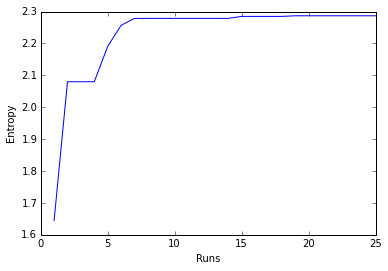

In [12]:
if not PYBOLT:
    %matplotlib inline

    plt.xlabel("Runs")
    plt.ylabel("Entropy")
    plt.plot(range(1, RUNS + 1), entropy)
    2**entropy[-1]

$$
F(i) = H(G_1, G_2, ..., G_i) 
$$

$F(i)$ stablizes multiple runs, thus the clustering is stable 

## Print the final results

In [13]:
print 'entropy=', entropy
best = np.argmin(cost)
print 'best_centers=', list(centroids[best])

entropy= [1.6445469704935676, 2.0800064512748428, 2.080006451274842, 2.0800064512748424, 2.1906681946052755, 2.2570115065383876, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2786597860645403, 2.2786597860645408, 2.2786597860645408, 2.2786597860645408, 2.2849509629282276, 2.2849509629282276, 2.2849509629282276, 2.2849509629282272, 2.286874405497795, 2.2868744054977945, 2.2868744054977945, 2.286874405497795, 2.2868744054977945, 2.286874405497795, 2.286874405497795]
best_centers= [array([ 2952.76608   ,  1933.02980077,    92.424188  , -2547.74851278,
         144.84123959,   154.0172669 ,    18.40817384,     7.84926361,
           5.11113863]), array([  428.4738994 ,  1807.58033164,    35.14799298, -2574.43476306,
        -180.39839191,   263.09089521,  6048.90511888,  -743.20856056,
         256.68319372]), array([ 1492.0570036 ,  1954.30230067,    94.48584365, -2567.99675086,
        -112.2682711 ,   152.28015089,   395.84574671,   131.09390181,
    